# Dual-Collaborative Filtering Autoencoder Metric Network

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import math
import os


def sparseEmbed(df, name, num, colIdx):
    embedName = [ name+"_"+str(i) for i in range(num)] 
    Emptydf = pd.DataFrame()
    Emptydf[embedName] = df[name].str.split('|',expand=True)
    values = np.unique(Emptydf[embedName].values)
    
    dic = {}
    a = 0
    for i in values:
        dic[i] = a
        a += 1
    dic.pop('nan', None)
    
    
    appendValue = np.zeros([Emptydf.values.shape[0], len(values)])
    for i in range(Emptydf.values.shape[0]):
        for j in range(num):
            key = Emptydf.values[i][j]
            if key in dic:
                appendValue[i][dic[key]] = 1
    
    for i in range(appendValue.shape[1], 0, -1):
        df.insert(colIdx, name+"_"+str(i-1), appendValue[:, i-1])
    
    del df[name]
    return df

def toDummy(df, name, colIdx):
    num = len(np.unique(df[name].values.astype(str)))-1
    embedName = [ name+"_"+str(i) for i in range(num)]  # don't need nan value
        
    dic = {}
    a = 0
    for i in range(num+1):
        dic[i] = a
        a += 1
    dic.pop('nan', None)
        
    appendValue = np.zeros([df[name].size, a])
    for i in range(df[name].size):
        key = df[name].values[i]
        if key in dic:
            appendValue[i][dic[key]] = 1
    
    for i in range(appendValue.shape[1], 0, -1):
        df.insert(colIdx, name+"_"+str(i-1), appendValue[:, i-1])
    
    del df[name]
    return df

def genderDummy(df, name, colIdx):
    pool = set()
    num = len(np.unique(df[name].values))-1
    for i in df[name].values:
        pool.add(str(i))
    num = len(list(pool))-1
    embedName = [ name+"_"+str(i) for i in range(num)]  # don't need nan value
        
    dic = {}
    a = 0
    for i in range(num+1):
        dic[i] = a
        a += 1
    dic.pop('nan', None)
        
    appendValue = np.zeros([df[name].size, a])
    for i in range(df[name].size):
        key = df[name].values[i]
        if key in dic:
            appendValue[i][dic[key]] = 1
    
    for i in range(appendValue.shape[1], 0, -1):
        df.insert(colIdx, name+"_"+str(i-1), appendValue[:, i-1])
    
    del df[name]
    return df

# Importing data and transforming to categorical binary input data form

In [3]:
head = ["user_age", "user_gender", "user_7_hero", "user_30_hero", "user_7_keyword", "user_7_author", "item_rate", "item_keyword", "item_author", "item_avgTime", "item_numReader", "item_numTime", "label"]
raw = pd.read_csv("./thing.txt", names=head, sep=",", index_col = False)

colIdx = raw.columns.values.tolist().index("user_gender")
raw = genderDummy(raw, "user_gender", colIdx)
colIdx = raw.columns.values.tolist().index("item_keyword")
raw = toDummy(raw, "item_keyword", colIdx)

numDic = {"user_gender": 1, "user_7_hero": 5, "user_30_hero": 5, "user_7_keyword": 3, "user_7_author": 3, "item_keyword": 1, "item_author": 3}
for i in ["user_7_hero", "user_30_hero", "user_7_keyword", "user_7_author", "item_author"]:
    colIdx = raw.columns.values.tolist().index(i)
    raw = sparseEmbed(raw, i, numDic[i], colIdx)
    print("finished with", i)

# normalize numerical features into interval [0, 1]
for i in ["user_age", "item_rate", "item_avgTime", "item_numReader", "item_numTime"]:
    r = raw[i].values.astype(float)
    min_max_scaler = MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(r.reshape(-1,1))
    raw_normalized = pd.DataFrame(x_scaled)
    raw[i] = raw_normalized

raw = raw.sample(200000)
    
raw.head()

finished with user_7_hero
finished with user_30_hero
finished with user_7_keyword
finished with user_7_author
finished with item_author


,user_age,user_gender_0,user_gender_1,user_gender_2,user_gender_3,user_7_hero_0,user_7_hero_1,user_7_hero_2,user_7_hero_3,user_7_hero_4,...,item_author_519,item_author_520,item_author_521,item_author_522,item_author_523,item_author_524,item_avgTime,item_numReader,item_numTime,label
2496,0.400000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.013336,0.745461,0.069180,0.0
347415,0.293333,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.044509,0.030982,0.009596,1.0
369533,0.346667,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.071564,0.529903,0.263886,1.0
239150,0.360000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.215608,0.220345,0.330593,1.0
59615,0.213333,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.114120,0.143617,0.114050,0.0


In [23]:
data = raw.sample(5000)

# Splitting dataframe into train, validation, and testing
dataY = data['label'].values
dataX = data.drop(columns = 'label').values


X, Xtest, Y, Ytest = train_test_split(dataX, dataY, test_size = 0.2, random_state = 42)
Xtrain, Xval, Ytrain, Yval = train_test_split(X, Y, test_size = 0.25, random_state = 42)

print("training data size: {} | validate data size: {} | testing data size: {}".format(str(Xtrain.shape), str(Xval.shape), str(Xtest.shape)))


# Training Parameters
learning_rate = 0.5
batch_size = 2048
epochs = 800


# Network Parameters
num_input = Xtrain.shape[1]
num_input_p = data.columns.values.tolist().index("item_rate") # number of all user input columns, the last column ends before the start of "item_rate" column
num_input_g = data.columns.values.shape[0] - num_input_p - 1   # number of all item input columns, = all column -user -label

a = 8
num_encode_1 = int(256 *a)
num_encode_2 = int(128 *a)
num_encode_3 = int(64 *a)
num_encode_4 = int(32 *a)
num_encode_5 = int(16*a)
num_encode_6 = int(16*a)

num_neck = 100

num_decode_1 = num_encode_3
num_decode_2 = num_encode_2
num_decode_3 = num_encode_1

num_output_to_p = num_input_p
num_output_to_g = num_input_g

#del raw


# balance weight coefficient [0,1], the bigger the mode focused onto neck distance
alpha = 0.3

# regularization
beta = 0.0005

# collaborative autoencoder input tensor1
X = tf.placeholder("float", [None, num_input])
label = tf.placeholder("float", [None, 1])

weights = {
    'encoder_ph1': tf.Variable(tf.random_normal([num_input_p , num_encode_1])),
    'encoder_gh1': tf.Variable(tf.random_normal([num_input_g , num_encode_1])),
    'encoder_ph2': tf.Variable(tf.random_normal([num_encode_1 , num_encode_2])),
    'encoder_gh2': tf.Variable(tf.random_normal([num_encode_1 , num_encode_2])),
    'encoder_ph3': tf.Variable(tf.random_normal([num_encode_2 , num_encode_3])),
    'encoder_gh3': tf.Variable(tf.random_normal([num_encode_2 , num_encode_3])),    
    'encoder_ph4': tf.Variable(tf.random_normal([num_encode_3 , num_encode_4])),
    'encoder_gh4': tf.Variable(tf.random_normal([num_encode_3 , num_encode_4])),    
    'encoder_ph5': tf.Variable(tf.random_normal([num_encode_4 , num_encode_5])),
    'encoder_gh5': tf.Variable(tf.random_normal([num_encode_4 , num_encode_5])),    
    'encoder_ph6': tf.Variable(tf.random_normal([num_encode_5 , num_encode_6])),
    'encoder_gh6': tf.Variable(tf.random_normal([num_encode_5 , num_encode_6])),        
    
    'encoder_pneck': tf.Variable(tf.random_normal([num_encode_6 , num_neck])), ## METRIC SPACE OF PERSON
    'encoder_gneck': tf.Variable(tf.random_normal([num_encode_6 , num_neck])), ## METRIC SPACE OF GOODS
    
    'decoder_gh1': tf.Variable(tf.random_normal([num_neck , num_decode_1])),
    'decoder_ph1': tf.Variable(tf.random_normal([num_neck , num_decode_1])),
    'decoder_gh2': tf.Variable(tf.random_normal([num_decode_1 , num_decode_2])),
    'decoder_ph2': tf.Variable(tf.random_normal([num_decode_1 , num_decode_2])),
    
    
    'decoder_gh3': tf.Variable(tf.random_normal([num_decode_2 , num_decode_3])),
    'decoder_ph3': tf.Variable(tf.random_normal([num_decode_2 , num_decode_3])),    
    
    
    'decoder_g_to_p_out': tf.Variable(tf.random_normal([num_decode_3 , num_output_to_p])),
    'decoder_p_to_g_out': tf.Variable(tf.random_normal([num_decode_3 , num_output_to_g]))
}

biases = {  
    'encoder_bph1': tf.Variable(tf.random_normal([num_encode_1])),
    'encoder_bgh1': tf.Variable(tf.random_normal([num_encode_1])),
    'encoder_bph2': tf.Variable(tf.random_normal([num_encode_2])),
    'encoder_bgh2': tf.Variable(tf.random_normal([num_encode_2])),
    'encoder_bph3': tf.Variable(tf.random_normal([num_encode_3])),
    'encoder_bgh3': tf.Variable(tf.random_normal([num_encode_3])),
    'encoder_bph4': tf.Variable(tf.random_normal([num_encode_4])),
    'encoder_bgh4': tf.Variable(tf.random_normal([num_encode_4])),    
    'encoder_bph5': tf.Variable(tf.random_normal([num_encode_5])),
    'encoder_bgh5': tf.Variable(tf.random_normal([num_encode_5])),   
    'encoder_bph6': tf.Variable(tf.random_normal([num_encode_6])),
    'encoder_bgh6': tf.Variable(tf.random_normal([num_encode_6])),       
    
    'encoder_bpneck': tf.Variable(tf.random_normal([num_neck])), ## METRIC SPACE OF PERSON
    'encoder_bgneck': tf.Variable(tf.random_normal([num_neck])), ## METRIC SPACE OF GOODS
    'decoder_bgh1': tf.Variable(tf.random_normal([num_decode_1])),
    'decoder_bph1': tf.Variable(tf.random_normal([num_decode_1])),
    'decoder_bgh2': tf.Variable(tf.random_normal([num_decode_2])),
    'decoder_bph2': tf.Variable(tf.random_normal([num_decode_2])),
    
    
    'decoder_bgh3': tf.Variable(tf.random_normal([num_decode_3])),
    'decoder_bph3': tf.Variable(tf.random_normal([num_decode_3])),    
    
    
    'decoder_b_g_to_p_out': tf.Variable(tf.random_normal([num_output_to_p])),
    'decoder_b_p_to_g_out': tf.Variable(tf.random_normal([num_output_to_g]))
}

# Building the encoder
def encoder(x):

    ## Person encoder:
    layer_p_1 = tf.nn.relu(tf.add(tf.matmul(x[:, :1376], weights['encoder_ph1']), biases['encoder_bph1']))  ## HARD CODING: 1375 is the ending index of person feature; 1376 the starting index of goods feature
    layer_p_2 = tf.nn.relu(tf.add(tf.matmul(layer_p_1, weights['encoder_ph2']), biases['encoder_bph2']))
    layer_p_3 = tf.nn.relu(tf.add(tf.matmul(layer_p_2, weights['encoder_ph3']), biases['encoder_bph3']))
    layer_p_4 = tf.nn.relu(tf.add(tf.matmul(layer_p_3, weights['encoder_ph4']), biases['encoder_bph4']))
    layer_p_5 = tf.nn.relu(tf.add(tf.matmul(layer_p_4, weights['encoder_ph5']), biases['encoder_bph5']))
    layer_p_6 = tf.nn.relu(tf.add(tf.matmul(layer_p_5, weights['encoder_ph6']), biases['encoder_bph6']))
    
    layer_p_neck = tf.nn.sigmoid(tf.add(tf.matmul(layer_p_6, weights['encoder_pneck']), biases['encoder_bpneck']))
    
    ## Good encoder
    layer_g_1 = tf.nn.relu(tf.add(tf.matmul(x[:, 1376:], weights['encoder_gh1']), biases['encoder_bgh1']))  ## HARD CODING: 1375 is the ending index of person feature; 1376 the starting index of goods feature
    layer_g_2 = tf.nn.relu(tf.add(tf.matmul(layer_g_1, weights['encoder_gh2']), biases['encoder_bgh2']))
    layer_g_3 = tf.nn.relu(tf.add(tf.matmul(layer_g_2, weights['encoder_gh3']), biases['encoder_bgh3']))   
    layer_g_4 = tf.nn.relu(tf.add(tf.matmul(layer_g_3, weights['encoder_gh4']), biases['encoder_bgh4']))   
    layer_g_5 = tf.nn.relu(tf.add(tf.matmul(layer_g_4, weights['encoder_gh5']), biases['encoder_bgh5']))   
    layer_g_6 = tf.nn.relu(tf.add(tf.matmul(layer_g_5, weights['encoder_gh6']), biases['encoder_bgh6']))
    
    layer_g_neck = tf.nn.sigmoid(tf.add(tf.matmul(layer_g_6, weights['encoder_gneck']), biases['encoder_bgneck']))
    
    
    return layer_p_neck, layer_g_neck


# Building the decoder
def decoder(p_neck, g_neck):
    
    ## Good to Person decoder
    layer_g_1 = tf.nn.relu(tf.add(tf.matmul(g_neck, weights['decoder_gh1']), biases['decoder_bgh1']))
    layer_g_2 = tf.nn.relu(tf.add(tf.matmul(layer_g_1, weights['decoder_gh2']), biases['decoder_bgh2']))
    layer_g_3 = tf.nn.relu(tf.add(tf.matmul(layer_g_2, weights['decoder_gh3']), biases['decoder_bgh3']))

    layer_g_to_p_out = tf.nn.sigmoid(tf.add(tf.matmul(layer_g_3, weights['decoder_g_to_p_out']), biases['decoder_b_g_to_p_out']))

    
    
    ## Person to Good decoder
    layer_p_1 = tf.nn.relu(tf.add(tf.matmul(p_neck, weights['decoder_ph1']), biases['decoder_bph1']))
    layer_p_2 = tf.nn.relu(tf.add(tf.matmul(layer_p_1, weights['decoder_ph2']), biases['decoder_bph2']))
    layer_p_3 = tf.nn.relu(tf.add(tf.matmul(layer_p_2, weights['decoder_ph3']), biases['decoder_bph3']))

    layer_p_to_g_out = tf.nn.sigmoid(tf.add(tf.matmul(layer_p_3, weights['decoder_p_to_g_out']), biases['decoder_b_p_to_g_out']))
    
    result = tf.concat([layer_g_to_p_out, layer_p_to_g_out], axis = 1)
    
    return result

def getl2loss(dic):
    l2 = 0
    for i in dic.keys():
        l2 += tf.nn.l2_loss(dic[i])
    return l2

# Construct model

encoder_p, encoder_g = encoder(X)
decoder_out = decoder(encoder_p, encoder_g)

# Prediction
y_pred = decoder_out
# Targets (Labels) are the input data.
y_true = X


# calculate l2 distance
neck_distance_l2 = tf.reshape(tf.norm(encoder_p-encoder_g, axis = 1), [-1,1])




# calculate l infinity distance
neck_distance = tf.reshape(tf.norm(encoder_p - encoder_g, axis=1, ord=np.inf), [-1,1])

signed_distance = tf.multiply(neck_distance, 2*label-1)
negative_mask = tf.less_equal(signed_distance, 0) # Getting a boolean vector that have TRUE for negative entries
positive_mask = tf.greater(signed_distance, 0)

training = tf.Variable(False)
pos_neg_break = tf.Variable(0)


if training:
    furthest_positive = tf.reduce_mean(tf.boolean_mask(signed_distance, positive_mask))
    closest_negative = -tf.reduce_mean(tf.boolean_mask(signed_distance, negative_mask))
    
    threshold = (furthest_positive + closest_negative) / 2
else:
    # TESTING: Plug-in pre-determined connec
    threshold = pos_neg_break

    
# Calculating AUC
neck_pred = tf.less_equal(neck_distance, threshold) # neck distance based prediction on clicking


# 4 different losses


sign = 2*label-1
loss_neck_distance = tf.reduce_mean(tf.maximum(0.0, 0.6*threshold+np.multiply(sign, signed_distance-threshold)))



#signed_centered_distance = -(neck_distance - tf.reduce_mean(neck_distance))
#loss_neck_distance = tf.losses.hinge_loss(label, signed_centered_distance)

loss_pred_distance = tf.reduce_mean(tf.pow(y_true - y_pred, 2))
loss_weights = tf.reduce_sum(getl2loss(weights))
loss_bias = tf.reduce_sum(getl2loss(biases))

loss = alpha * loss_neck_distance + (1-alpha) * loss_pred_distance + beta * (loss_weights + loss_bias)

# Define Optimizer
p_var_list = [weights["encoder_ph1"], weights["encoder_ph2"], weights["encoder_ph3"], weights["encoder_ph4"], weights["encoder_ph5"], weights["encoder_ph6"], weights["encoder_pneck"], 
              weights["decoder_ph1"], weights["decoder_ph2"], weights["decoder_ph3"], weights["decoder_p_to_g_out"],
              biases["encoder_bph1"], biases["encoder_bph2"], biases["encoder_bph3"], biases["encoder_bph4"], biases["encoder_bph5"], biases["encoder_bph6"], biases["encoder_bpneck"], 
              biases["decoder_bph1"], biases["decoder_bph2"], biases["decoder_bph3"], biases["decoder_b_p_to_g_out"]]

g_var_list = [weights["encoder_gh1"], weights["encoder_gh2"], weights["encoder_gh3"], weights["encoder_gh4"], weights["encoder_gh5"], weights["encoder_gh6"], weights["encoder_gneck"], 
              weights["decoder_gh1"], weights["decoder_gh2"], weights["decoder_gh3"], weights["decoder_g_to_p_out"],
              biases["encoder_bgh1"], biases["encoder_bgh2"], biases["encoder_bgh3"], biases["encoder_bgh4"], biases["encoder_bgh5"], biases["encoder_bgh6"], biases["encoder_bgneck"], 
              biases["decoder_bgh1"], biases["decoder_bgh2"], biases["decoder_bgh3"], biases["decoder_b_g_to_p_out"]]

optimizer_p = tf.train.RMSPropOptimizer(learning_rate).minimize(loss, var_list = p_var_list)
optimizer_g = tf.train.RMSPropOptimizer(learning_rate).minimize(loss, var_list = g_var_list)


"""gvs_p = optimizer_p.compute_gradients(loss, var_list = p_var_list)
capped_gvs_p = [(tf.clip_by_value(grad, -10., 10.), var) for grad, var in gvs_p]
train_op_p = optimizer_p.apply_gradients(capped_gvs)

gvs_g = optimizer_g.compute_gradients(loss, var_list = g_var_list)
capped_gvs_g = [(tf.clip_by_value(grad, -10., 10.), var) for grad, var in gvs_g]
train_op_g = optimizer_g.apply_gradients(capped_gvs)"""

# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()
local_init = tf.local_variables_initializer()


# Start Training
# Start a new TF session
with tf.Session() as sess:
    

    # Run the initializer
    sess.run(init)
    sess.run(local_init)
    
    
    num_train_batches = int(Xtrain.shape[0] / batch_size)
    Xtrain = np.array_split(Xtrain, num_train_batches)
    Ytrain = np.array_split(Ytrain, num_train_batches)
    
    for i in range(len(Ytrain)):
        Ytrain[i] = np.reshape(Ytrain[i], [-1,1])
    Yval = np.reshape(Yval, [-1,1])

    
    # Training with validating
    true_false_break = 0.5
    
    for i in range(epochs):

        avg_train_cost = 0
        avg_train_neck_cost = 0
        avg_auc = 0
        for batch in range(len(Xtrain)):

            # optimize the person side
            _, l, neck, max_pos_dist, min_neg_dist, pred_train, neck_dis = sess.run([optimizer_p, loss, loss_neck_distance, furthest_positive, closest_negative, neck_pred, neck_distance_l2],  
                                                        #{optimizer:_, loss:l, loss_neck_distance:neck, threshold:true_false_break, furthest_positive:max_pos_dist, closest_negative:min_neg_dist, neck_pred:pred_train, neck_distance = neck_dis}
                                                        feed_dict={X: Xtrain[batch], label: Ytrain[batch], training: False, pos_neg_break: true_false_break}) # because it is training, it doesn't matter what's the value of pos_neg_break 
           # optimize the goods side
            _, l, neck, max_pos_dist, min_neg_dist, pred_train, neck_dis = sess.run([optimizer_g, loss, loss_neck_distance, furthest_positive, closest_negative, neck_pred, neck_distance_l2],  
                                                        #{optimizer:_, loss:l, loss_neck_distance:neck, threshold:true_false_break, furthest_positive:max_pos_dist, closest_negative:min_neg_dist, neck_pred:pred_train}
                                                        feed_dict={X: Xtrain[batch], label: Ytrain[batch], training: False, pos_neg_break: true_false_break}) # because it is training, it doesn't matter what's the value of pos_neg_break 
            #print(l)
            """print(Xtrain[batch][0])
            print(Ytrain[batch][0])"""
            
            avg_train_cost += l
            avg_train_neck_cost += neck
            avg_auc += roc_auc_score(Ytrain[batch], pred_train) # adding training batch training auc score
        
        avg_train_cost /= num_train_batches
        avg_train_neck_cost /= num_train_batches
        avg_auc /= num_train_batches # averaging out training batch auc score
        
        """print(Xval[0])
        print(Yval[0])"""
        
        # Validate once an epoch ends
        val_cost, val_neck_cost, pred_val, neck_dis_val = sess.run([loss, loss_neck_distance, neck_pred, neck_distance_l2], # {loss:val_cost, loss_neck_distance:val_neck_cost, neck_pred:pred_val}
                                                    feed_dict={X: Xval, label: Yval, training: False, pos_neg_break: true_false_break})
        val_auc = roc_auc_score(Yval, pred_val) # getting validation auc score
        
        
        
        if i % 50 == 0:
            # look at the training metric space
            signed = np.multiply(neck_dis.flatten(), 2*Ytrain[batch].flatten()-1)
            pos = []
            neg = []
            for dist in signed:
                if dist >= 0:
                    pos.append(dist)
                else:
                    neg.append(dist)


            pos = np.array(pos)
            neg = np.array(neg)

            a = np.mean(pos)
            b = np.mean(neg)
            
            
            # look at the validation metric space
            signed_val = np.multiply(neck_dis_val.flatten(), 2*Yval.flatten()-1)
            pos_val = []
            neg_val = []
            for dist_val in signed_val:
                if dist_val >= 0:
                    pos_val.append(dist_val)
                else:
                    neg_val.append(dist_val)

            pos_val = np.array(pos_val)
            neg_val = np.array(neg_val)

            a_val = np.mean(pos_val)
            b_val = np.mean(neg_val)
            
            
            if i >= 2000:
                plt.figure(figsize=(12, 4))
                sns.set(color_codes=True)
                sns.distplot(pos, bins=20, kde = False, color="r", label="red: pos dis")
                sns.distplot(-neg, bins=20, kde = False , color="b", label="blue: neg dis")
                plt.legend()
                plt.xlim(0, 1)
                plt.show()
      
                plt.figure(figsize=(12, 4))
                sns.set(color_codes=True)
                sns.distplot(pos_val, bins=20, kde = False, color="r", label="red: pos dis")
                sns.distplot(-neg_val, bins=20, kde = False , color="b", label="blue: neg dis")
                plt.legend()
                plt.xlim(0, 1)
                plt.show()
                
            #true_false_break = math.sqrt(num_neck) / 2
                        
            print("Epoch: {:>3} | Train Loss: {:+8.2f} | Val Loss: {:+8.3f} | Train Neck: {:+8.3f} | Val Neck: {:+8.3f} | Train AUC: {:+8.3f} | Val AUC: {:+8.3f} | TF Break: {:06.3f} | mean pos dist: {:06.3f} | mean neg dist {:06.3f} "
                  .format( i + 1,        avg_train_cost, val_cost,     avg_train_neck_cost, val_neck_cost,   avg_auc,val_auc,   true_false_break, a, -b))
            
    Ytest = np.reshape(Ytest, [-1,1])

        
    # Testing
    test_cost, test_neck_cost, pred_test = sess.run([loss, loss_neck_distance, neck_pred],  # {loss:test_cost, loss_neck_distance:test_neck_cost, neck_pred:pred_test}
                                                   feed_dict={X: Xtest, label: Ytest, training: False, pos_neg_break: true_false_break})
    test_auc = roc_auc_score(Ytest, pred_test)  # getting testing auc score
    print("Test Loss: {:02.5f} | Neck Loss: {:02.5f} | AUC: {:02.5f}".format(test_cost, test_neck_cost, test_auc))

training data size: (3000, 2118) | validate data size: (1000, 2118) | testing data size: (1000, 2118)
Epoch:   1 | Train Loss:  +319.58 | Val Loss: +319.566 | Train Neck:   +1.711 | Val Neck:   +1.722 | Train AUC:   +0.500 | Val AUC:   +0.500 | TF Break: 00.500 | mean pos dist: 07.382 | mean neg dist 07.397 
Epoch:  51 | Train Loss:  +311.44 | Val Loss: +311.210 | Train Neck:   +1.711 | Val Neck:   +1.722 | Train AUC:   +0.500 | Val AUC:   +0.500 | TF Break: 00.500 | mean pos dist: 07.309 | mean neg dist 07.345 
Epoch: 101 | Train Loss:  +217.68 | Val Loss: +215.478 | Train Neck:   +1.711 | Val Neck:   +1.722 | Train AUC:   +0.500 | Val AUC:   +0.500 | TF Break: 00.500 | mean pos dist: 07.093 | mean neg dist 07.096 
Epoch: 151 | Train Loss:    +3.34 | Val Loss:   +2.989 | Train Neck:   +0.955 | Val Neck:   +0.962 | Train AUC:   +0.489 | Val AUC:   +0.513 | TF Break: 00.500 | mean pos dist: 04.627 | mean neg dist 04.628 
Epoch: 201 | Train Loss:    +0.08 | Val Loss:   +0.140 | Train Nec

# Apply Compressed Sensing to hash high dimensional sparse binary feature group into numerical low dimensional representation

In [ ]:
# Getting sparse feature group begin and ending column indecies
user_sparse_feat = ["user_gender_0", "user_7_hero_0", "user_30_hero_0", "user_7_keyword_0", "user_7_author_0", "item_rate"]
item_sparse_feat = ["item_keyword_0", "item_author_0", "item_avgTime"] 

user_sparse_feat_beginEnd = []
item_sparse_feat_beginEnd = []

for i in range(len(user_sparse_feat)-1):
    begin = raw.columns.values.tolist().index(user_sparse_feat[i])
    end = raw.columns.values.tolist().index(user_sparse_feat[i+1])-1
    user_sparse_feat_beginEnd.append((begin, end))
    
for i in range(len(item_sparse_feat)-1):
    begin = raw.columns.values.tolist().index(item_sparse_feat[i])
    end = raw.columns.values.tolist().index(item_sparse_feat[i+1])-1
    item_sparse_feat_beginEnd.append((begin, end))
    
print("user sparse feature begin end index:", str(user_sparse_feat_beginEnd))
print("item sparse feature begin end index:", str(item_sparse_feat_beginEnd))

# 

# Compressed sensing

In [ ]:
print(__doc__)

# Author: Emmanuelle Gouillart <emmanuelle.gouillart@nsup.org>
# License: BSD 3 clause

import numpy as np
from scipy import sparse
from scipy import ndimage
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt


def _weights(x, dx=1, orig=0):
    x = np.ravel(x)
    floor_x = np.floor((x - orig) / dx).astype(np.int64)
    alpha = (x - orig - floor_x * dx) / dx
    return np.hstack((floor_x, floor_x + 1)), np.hstack((1 - alpha, alpha))


def _generate_center_coordinates(l_x):
    X, Y = np.mgrid[:l_x, :l_x].astype(np.float64)
    center = l_x / 2.
    X += 0.5 - center
    Y += 0.5 - center
    return X, Y


def build_projection_operator(l_x, n_dir):
    """ Compute the tomography design matrix.

    Parameters
    ----------

    l_x : int
        linear size of image array

    n_dir : int
        number of angles at which projections are acquired.

    Returns
    -------
    p : sparse matrix of shape (n_dir l_x, l_x**2)
    """
    X, Y = _generate_center_coordinates(l_x)
    angles = np.linspace(0, np.pi, n_dir, endpoint=False)
    data_inds, weights, camera_inds = [], [], []
    data_unravel_indices = np.arange(l_x ** 2)
    data_unravel_indices = np.hstack((data_unravel_indices,
                                      data_unravel_indices))
    for i, angle in enumerate(angles):
        Xrot = np.cos(angle) * X - np.sin(angle) * Y
        inds, w = _weights(Xrot, dx=1, orig=X.min())
        mask = np.logical_and(inds >= 0, inds < l_x)
        weights += list(w[mask])
        camera_inds += list(inds[mask] + i * l_x)
        data_inds += list(data_unravel_indices[mask])
    proj_operator = sparse.coo_matrix((weights, (camera_inds, data_inds)))
    return proj_operator


def generate_synthetic_data():
    """ Synthetic binary data """
    rs = np.random.RandomState(0)
    n_pts = 36
    x, y = np.ogrid[0:l, 0:l]
    mask_outer = (x - l / 2.) ** 2 + (y - l / 2.) ** 2 < (l / 2.) ** 2
    mask = np.zeros((l, l))
    points = l * rs.rand(2, n_pts)
    mask[(points[0]).astype(np.int), (points[1]).astype(np.int)] = 1
    mask = ndimage.gaussian_filter(mask, sigma=l / n_pts)
    res = np.logical_and(mask > mask.mean(), mask_outer)
    return np.logical_xor(res, ndimage.binary_erosion(res))


# Generate synthetic images, and projections
l = 128
proj_operator = build_projection_operator(l, l // 2)
data = generate_synthetic_data()


proj = proj_operator * data.ravel()[:, np.newaxis]
proj += 0.15 * np.random.randn(*proj.shape)



# Reconstruction with L1 (Lasso) penalization
# the best value of alpha was determined using cross validation
# with LassoCV
rgr_lasso = Lasso(alpha=0.001)
rgr_lasso.fit(proj_operator, proj.ravel())
rec_l1 = rgr_lasso.coef_.reshape(l, l)

plt.figure(figsize=(8, 3.3))
plt.subplot(131)
plt.imshow(data, cmap=plt.cm.gray, interpolation='nearest')
plt.axis('off')
plt.title('original image')
plt.subplot(132)

plt.imshow(rec_l1, cmap=plt.cm.gray, interpolation='nearest')
plt.title('L1 penalization')
plt.axis('off')

plt.subplots_adjust(hspace=0.01, wspace=0.01, top=1, bottom=0, left=0,
                    right=1)

plt.show()

In [ ]:
raw.drop(columns='label', axis=1)


In [ ]:
raw.head()

In [8]:
fuck_true = np.array([0, 0, 1, 1])
fuck_scores = np.array([False, False, False, True])
roc_auc_score(fuck_true, fuck_scores)

0.75

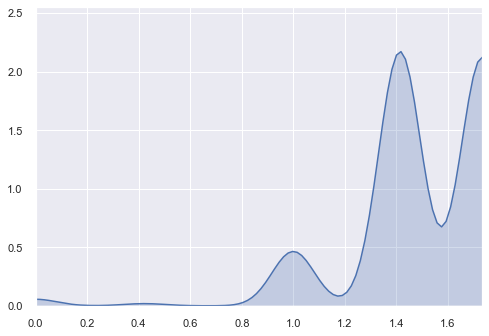

In [69]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
import seaborn as sns

iris = load_iris()
iris = pd.DataFrame(data=np.c_[iris['data'], iris['target']],
                    columns=iris['feature_names'] + ['target'])

# Sort the dataframe by target
target_0 = iris.loc[iris['target'] == 0]
target_1 = iris.loc[iris['target'] == 1]
target_2 = iris.loc[iris['target'] == 2]

sns.distplot(pos, hist=False, kde_kws={"shade": True})
sns.distplot(neg, hist=False, kde_kws={"shade": True})
plt.show()

In [109]:
np.mean(Ytrain)

0.446

array([-0.00000000e+00, -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00, -0.00000000e+00,  1.78813920e-07,
       -0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00,  